# Biological Signals Analysis - Week 3 Exercise

### Created by Guy Singer | Jan. 17, 2024

### Table of Contents:
- Convolutions
  - Visual Example: Convolving the Rolls of Two Dice
  - Convolutions with the FFT
  - Python Example: Speeding Up Convolutions with FFT
- Simple Filters
- Comparing Finite Impulse Response (FIR) and Infinite Impulse Response (IIR) Filters
- Autoregressive Filter (Infinite Impulse Response, IIR)
- Finite Impulse Response (FIR) Filters


## Convolutions <a id="convolutions" ></a>

Convolution, often denoted with $ \circledast $ is a fundamental operation in signal processing, especially relevant in neurophysiological signal analysis. It involves combining two signals to form a third signal, illustrating how one signal modifies the other over time. Specifically, convolution is defined as **is defined as the integral of the product of the two functions after one is reversed and shifted.**. This is represented mathematically as follows:

$
(f * g)(t) = \int_{-\infty}^{\infty} f(\tau) g(t - \tau) d\tau
$

### Visual Example: Convolving The Outcome Distributions of two Dice

Imagine rolling a pair of dice and figuring out the chances of seeing various different sums.

Each of the two dice has six different possible outcomes, which yields a total of 36 distinct possible pairs of outcomes.

And if we just look through them all, we can count up how many pairs have a given sum.
When arranging all the pairs in a grid like the one shown below, all of
the pairs that have a constant sum are visible along one of the different diagonals in the grid.

So simply counting how many exist on each of those diagonals and dividing by the total number of possible outcomes will yield the likelihood you are to see a particular sum.

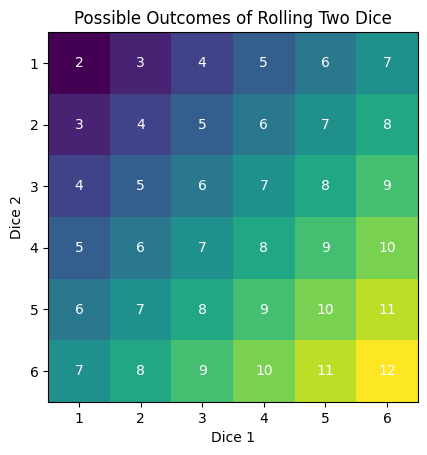

In [6]:
import matplotlib.pyplot as plt
import numpy as np

dice_rolls = np.zeros((6, 6), dtype=int)

for i in range(1, 7):
    for j in range(1, 7):
        dice_rolls[i-1, j-1] = i + j

fig, ax = plt.subplots()
ax.imshow(dice_rolls, cmap='viridis', interpolation='nearest')

for i in range(dice_rolls.shape[0]):
    for j in range(dice_rolls.shape[1]):
        ax.text(j, i, dice_rolls[i, j], ha='center', va='center', color='w')

ax.set_title('Possible Outcomes of Rolling Two Dice')
ax.set_xticks(np.arange(6))
ax.set_yticks(np.arange(6))
ax.set_xticklabels(np.arange(1, 7))
ax.set_yticklabels(np.arange(1, 7))
ax.set_xlabel('Dice 1')
ax.set_ylabel('Dice 2')
plt.show()

Let's say you picture these two different sets of possibilities each in a row, but you flip around that second row.
That way, all of the different pairs which add up to seven line up vertically like this:

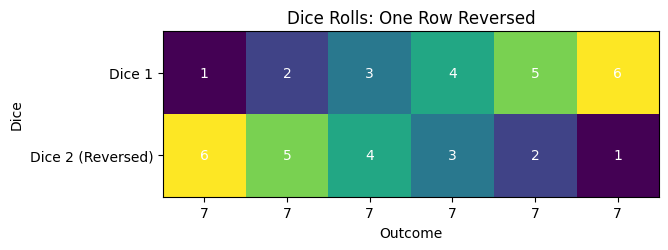

In [9]:
dice_rolls_modified = np.zeros((2, 6), dtype=int)
dice_rolls_modified[0, :] = np.arange(1, 7)
dice_rolls_modified[1, :] = np.arange(6, 0, -1)

fig, ax = plt.subplots()
ax.imshow(dice_rolls_modified, cmap='viridis', interpolation='nearest')

for i in range(dice_rolls_modified.shape[0]):
    for j in range(dice_rolls_modified.shape[1]):
        ax.text(j, i, dice_rolls_modified[i, j], ha='center', va='center', color='w')

ax.set_title('Dice Rolls: One Row Reversed')
ax.set_xticks(np.arange(6))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(['7'] * 6)
ax.set_yticklabels(['Dice 1', 'Dice 2 (Reversed)'])
ax.set_xlabel('Outcome')
ax.set_ylabel('Dice')

plt.show()

And if we slide that bottom row over, the pairs which align are the two different pairs that add up to four.
And in general, different off set values of this lower array, which remember, I had to flip around first, reveal all the distinct pairs that have a given sum.

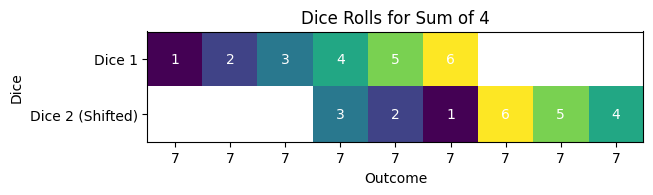

In [10]:
dice_rolls_sum_4 = np.full((2, 9), np.nan)
dice_rolls_sum_4[0, :6] = np.arange(1, 7)
dice_rolls_sum_4[1, 3:9] = np.array([3, 2, 1, 6, 5, 4])

fig, ax = plt.subplots()
ax.imshow(dice_rolls_sum_4, cmap='viridis', interpolation='nearest')

for i in range(dice_rolls_sum_4.shape[0]):
    for j in range(dice_rolls_sum_4.shape[1]):
        if not np.isnan(dice_rolls_sum_4[i, j]):
            ax.text(j, i, int(dice_rolls_sum_4[i, j]), ha='center', va='center', color='w')

ax.set_title('Dice Rolls for Sum of 4')
ax.set_xticks(np.arange(9))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(['7'] * 9)
ax.set_yticklabels(['Dice 1', 'Dice 2 (Shifted)'])
ax.set_xlabel('Outcome')
ax.set_ylabel('Dice')
plt.show()

### Convolutions with the FFT

We had started by stating that the convolution of two signals can be expressed as such: 

$
(f * g)(t) = \int_{-\infty}^{\infty} f(\tau) g(t - \tau) d\tau
$

Solving this integral is a complex operation. Not just for humans, but even for computing machines. The Fourier Transform significantly speeds up the process of convolving two functions by transforming the convolution operation in the time domain into a simpler multiplication operation in the frequency domain. This is based on the Convolution Theorem.

Let's consider two functions $ f $ and $ g $, and their convolution $ f \circledast g $. The convolution theorem states that:

$
\mathcal{F}\{f \circledast g\} = \mathcal{F}\{f\} \cdot \mathcal{F}\{g\}
$

where $ \mathcal{F}\{f\} $ and $ \mathcal{F}\{g\} $ are the Fourier Transforms of $ f $ and $ g $ respectively. This theorem implies that instead of directly convolving $ f $ and $ g $, we can:

1. Compute the Fourier Transforms of $ f $ and $ g $.
2. Multiply these transforms point-wise.
3. Apply the Inverse Fourier Transform to the result of this multiplication to obtain $ f * g $.

In other words, if $ f[n] $ and $ g[n] $ are two signals with Fourier Transforms $ f(\omega) $ and $ g(\omega) $ respectively, then the convolution of $ f[n] $ and $ g[n] $ is equivalent to the multiplication of $ f(\omega) $ and $ g(\omega) $:

$
y[n] \longleftrightarrow Y(\omega)
$

$
F\{f(t) \circledast g(t)\} = f(\omega) \cdot g(\omega) = Y(\omega)
$

The computational complexity advantage arises from the fact that the direct computation of the convolution is typically an $ O(n^2) $ operation, where $ n $ is the number of points in the functions $ f $ and $ g $. However, using the Fast Fourier Transform (FFT) algorithm, the Fourier Transform and its inverse can be computed in $ O(n \log n) $ time. This makes the overall process of computing the convolution via the Fourier Transform significantly faster for large $ n $, especially since the point-wise multiplication in the frequency domain is an $ O(n) $ operation.

In summary, the process using Fourier Transforms is:

1. FFT of $ f $: $ O(n \log n) $
2. FFT of $ g $: $ O(n \log n) $
3. Point-wise multiplication: $ O(n) $
4. Inverse FFT: $ O(n \log n) $

Hence, the total complexity is dominated by the FFT and its inverse, making it much faster than the direct \( O(n^2) $ convolution approach for large datasets.


### Python Example: Speeding Up Convolutions with Fourier Transforms

In [2]:
import numpy as np
from scipy.signal import fftconvolve
import timeit

# Generate two large random arrays
array1 = np.random.rand(10000)
array2 = np.random.rand(10000)

# Define functions for normal convolution and fft convolution
def normal_convolve():
    return np.convolve(array1, array2)

def fft_convolve():
    return fftconvolve(array1, array2)

# Measure time taken by each function
time_normal = timeit.timeit(normal_convolve, number=10)
time_fft = timeit.timeit(fft_convolve, number=10)

print(f"Time taken to convolve normally: {time_normal}")
print(f"Time taken to convolve with FFT: {time_fft}")

Time taken to convolve normally: 0.5540102920494974
Time taken to convolve with FFT: 0.0035117496736347675


## Simple Filters

## Comparing Finite Impulse Response (FIR) and Infinite Impulse Response (IIR) Filters <a id="firvsiir"></a>

Both FIR and IIR filters have their place in signal processing. FIR filters are preferred when phase linearity and stability are crucial, while IIR filters are more efficient and suited for applications where these concerns are secondary.

----------------------

### Finite Impulse Response (FIR) Filters

**Definition**: FIR filters produce an output that only depends on the current and a finite number of previous input values.

  $
  y[n] = \sum_{k=0}^{M-1} b_k \cdot x[n-k]
  $
  
  where $ y[n] $ is the output, $ x[n] $ is the input, $ b_k $ are the filter coefficients, and $ M $ is the order of the filter.

----------------------

### Infinite Impulse Response (IIR) Filters

**Definition**: IIR filters produce an output that depends on the current and previous input values as well as previous output values.

  $
  y[n] = \sum_{k=0}^{M-1} b_k \cdot x[n-k] - \sum_{k=1}^{N} a_k \cdot y[n-k]
  $

  where $ a_k $ are the feedback coefficients and $ N $ is the order of the feedback part of the filter.

----------------------

### Key Differences

1. **Impulse Response Duration**:
   - FIR: Has a finite duration, determined by the number of coefficients $ M $.
   - IIR: Theoretically infinite duration due to feedback; a single input can affect the output indefinitely.

2. **Stability**:
   - FIR: Inherently stable since the output does not depend on previous outputs.
   - IIR: Can be unstable if not properly designed, especially due to the feedback component.

3. **Phase Response**:
   - FIR: Can be easily designed to have a linear phase response, avoiding signal distortion.
   - IIR: Typically has a nonlinear phase response, which can cause signal distortion.

4. **Computational Complexity**:
   - FIR: Generally requires more computational resources for a comparable frequency response.
   - IIR: More computationally efficient due to feedback, but requires careful design to ensure stability.


## Autoregressive Filter (Infinite Impulse Response, IIR) <a id="iir"></a>

The autoregressive filter is a type of digital filter that operates on input signals to produce an output signal. Its primary characteristic is that the output is computed as a linear combination of the current and past input values as well as past output values. This recursive nature is why it's called "infinite impulse response" – theoretically, a single input impulse can affect the output indefinitely.

The general form of an autoregressive filter of order $p$ is given by:

$
y[n] = -\sum_{k=1}^{p} a_k \cdot y[n-k] + x[n]
$

Where:
- $y[n]$ is the output signal at time $n$,
- $x[n]$ is the input signal at time $ n $,
- $ a_k $ are the filter coefficients, and
- $ p $ is the order of the filter, determining how many past output values are used.

The negative sign in front of the summation indicates that the filter is typically implemented as a feedback system.


In neuroscience, autoregressive filters can be used for various purposes, such as:
- **Noise Reduction**: Reducing noise in neural recordings, thereby enhancing signal quality.
- **Feature Extraction**: Extracting features from neural signals for tasks like spike sorting or identifying specific neural patterns.
- **Signal Prediction**: Predicting future neural activity based on past data, which can be useful in brain-computer interfaces or understanding neural dynamics.


- **Stability**: Not all sets of coefficients $ a_k $ lead to a stable filter. Stability is typically ensured when the poles of the filter's transfer function are within the unit circle in the z-plane.
- **Design**: The design of the filter (choosing appropriate coefficients) is crucial and depends on the characteristics of the signal and the specific application in neuroscience.
- **Computational Efficiency**: Autoregressive filters are generally more computationally efficient than their non-recursive counterparts, making them suitable for real-time applications.


## Finite Impulse Response (FIR) Filters <a id='fir'></a>

Finite Impulse Response (FIR) filters are a class of digital filters that are critical in signal processing, particularly in the field of neuroscience. Unlike Infinite Impulse Response (IIR) filters, FIR filters have a finite duration of response to an input impulse, as their output is only dependent on current and past input values, not past output values. This characteristic makes FIR filters inherently stable and free from feedback loops.

### The Moving Average Filter - A Prime Example

A common example of an FIR filter is the Moving Average Filter, which is used to smooth data by averaging a set number of past input values. This is particularly useful in neuroscience for smoothing noisy neural data.

The Moving Average Filter can be mathematically expressed as:

$
y[n] = \frac{1}{M} \sum_{k=0}^{M-1} x[n-k]
$

Where:
- $ y[n] $ is the output signal at time $ n $,
- $ x[n] $ is the input signal at time $ n $,
- $ M $ is the number of points in the moving average, determining the length of the filter.

The output at each point $ n $ is the average of the last $ M $ input points, which smooths out rapid fluctuations in the input signal.

In neuroscience, the Moving Average Filter is particularly useful for:
- **Noise Reduction**: Smoothing out random noise in neural recordings.
- **Signal Preprocessing**: Preparing neural data for further analysis, such as feature extraction or spike detection.

- **Stability**: FIR filters are inherently stable, a desirable feature when dealing with sensitive neural data.
- **Linear Phase Response**: FIR filters can be designed to have a linear phase response, ensuring no phase distortion of the signal.
- **Flexibility in Design**: FIR filters can be tailored to specific requirements, such as specific frequency responses, making them versatile for various applications in neuroscience.